# ***OVERSAMPLING DATA***

In [116]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sns


## **Koneksi ke database**

In [117]:
load_dotenv()

# Ambil variabel dari .env
user_postgres = os.getenv("USER_POSTGRES")
password_postgres = os.getenv("PASS_POSTGRES")
host_postgres = os.getenv("HOST_POSTGRES")
port_postgres = os.getenv("PORT_POSTGRES")
db_postgres = os.getenv("DB_POSTGRES")

user_mysql = os.getenv("USER_MYSQL")
password_mysql = os.getenv("PASS_MYSQL")
host_mysql = os.getenv("HOST_MYSQL")
port_mysql = os.getenv("PORT_MYSQL")
db_mysql = os.getenv("DB_MYSQL")


postgres_conn = f"postgresql+psycopg2://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{db_postgres}"

mysql_conn = f"mysql+pymysql://{user_mysql}:{password_mysql}@{host_mysql}:{port_mysql}/{db_mysql}"

postgres_engine = create_engine(postgres_conn)
postgres_engine = create_engine(mysql_conn)

python-dotenv could not parse statement starting at line 16
python-dotenv could not parse statement starting at line 19


In [118]:
mysql_df_iris = pd.read_sql("SELECT id, class, petal_length, petal_width FROM iris_full", mysql_conn)
postgres_df_iris = pd.read_sql("SELECT id, sepal_length, sepal_width FROM iris_full", postgres_conn)

In [119]:
# mengabungkan 2 database
merge_df = pd.merge(mysql_df_iris, postgres_df_iris, left_on="id", right_on='id', how='outer')

In [120]:
print(merge_df)

      id           class  petal_length  petal_width  sepal_length  sepal_width
0      1     Iris-setosa           1.4          0.2           5.1          3.5
1      2     Iris-setosa           1.4          0.2           4.9          3.0
2      3     Iris-setosa           1.3          0.2           4.7          3.2
3      4     Iris-setosa           1.5          0.2           4.6          3.1
4      5     Iris-setosa           1.4          0.2           5.0          3.6
..   ...             ...           ...          ...           ...          ...
145  146  Iris-virginica           5.2          2.3           6.7          3.0
146  147  Iris-virginica           5.0          1.9           6.3          2.5
147  148  Iris-virginica           5.2          2.0           6.5          3.0
148  149  Iris-virginica           5.4          2.3           6.2          3.4
149  150  Iris-virginica           5.1          1.8           5.9          3.0

[150 rows x 6 columns]


In [121]:
table_iris = merge_df.copy()

## **Menghapus data dengan class setosa**

In [122]:
# Ambil semua iris-setosa
setosa = table_iris[table_iris["class"] == "Iris-setosa"]

# Sisakan hanya 15 data pertama
setosa_keep = setosa.head(15)

# Ambil data selain iris-setosa
non_setosa = table_iris[table_iris["class"] != "Iris-setosa"]

# Gabungkan kembali
table_iris = pd.concat([non_setosa, setosa_keep], ignore_index=True)

print(table_iris["class"].value_counts())


class
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        15
Name: count, dtype: int64


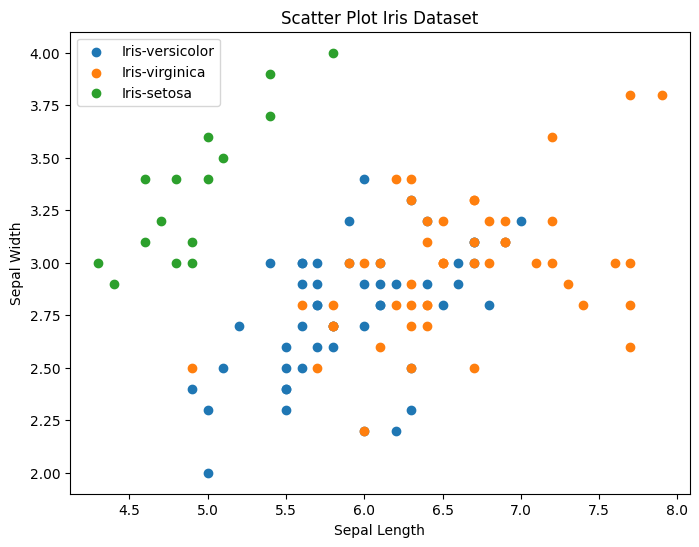

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for species in table_iris["class"].unique():
    subset = table_iris[table_iris["class"] == species]
    plt.scatter(subset["sepal_length"], subset["sepal_width"], label=species)

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Scatter Plot Iris Dataset")
plt.legend()
plt.show()


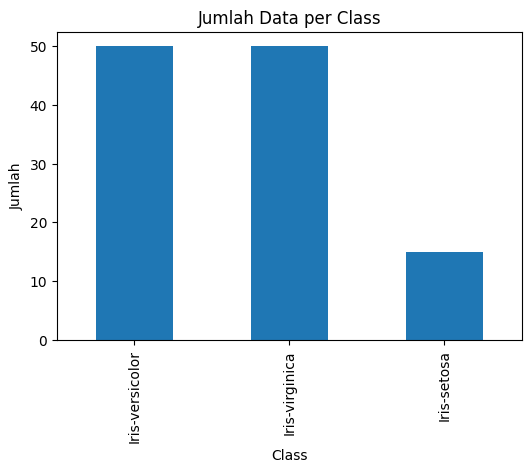

In [124]:
table_iris["class"].value_counts().plot(kind="bar", figsize=(6,4))

plt.title("Jumlah Data per Class")
plt.xlabel("Class")
plt.ylabel("Jumlah")
plt.show()


In [125]:
# Pisahkan fitur (X) dan label (y)
X = table_iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y = table_iris["class"].astype("category").cat.codes  # convert class ke angka 0,1,2
target_names = table_iris["class"].unique()          # nama class

explained variance ratio (first two components): [0.89519775 0.06768835]


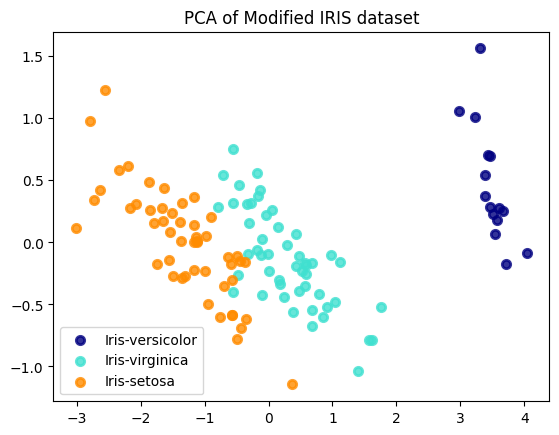

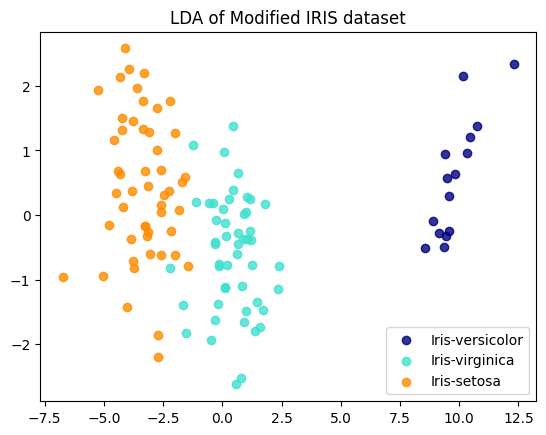

In [126]:
# PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

# Plot PCA
plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Modified IRIS dataset")

# Plot LDA
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of Modified IRIS dataset")

plt.show()


## **Syntesis Dataset dengan Algoritma SMOTE**

In [127]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Sesudah SMOTE:", Counter(y_res))

# Ubah kembali ke DataFrame agar mudah dianalisis
table_iris_balanced = pd.DataFrame(X_res, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
table_iris_balanced["class"] = [target_names[i] for i in y_res]

print(table_iris_balanced["class"].value_counts())

Sesudah SMOTE: Counter({1: 50, 2: 50, 0: 50})
class
Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64


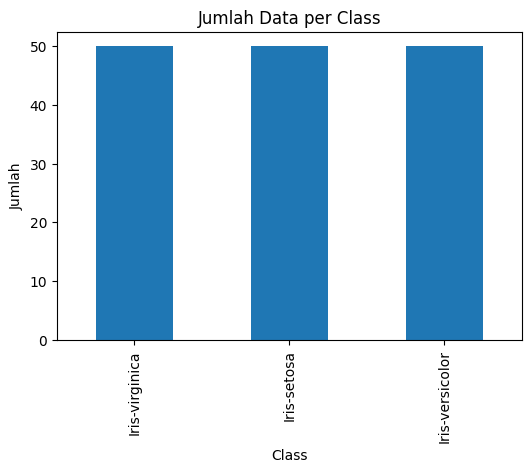

In [128]:
table_iris_balanced["class"].value_counts().plot(kind="bar", figsize=(6,4))

plt.title("Jumlah Data per Class")
plt.xlabel("Class")
plt.ylabel("Jumlah")
plt.show()


In [129]:
print(table_iris["class"].value_counts())

class
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        15
Name: count, dtype: int64


In [130]:
print(table_iris_balanced["class"].value_counts())

class
Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64


## **Melakukan Klasifikasi**

### *Dataset Iris Tidak Seimbang*

In [131]:
X_not_balance = table_iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y_not_balance = table_iris["class"].astype("category").cat.codes  # convert class ke angka 0,1,2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_not_balance, y_not_balance, test_size=0.2, random_state=42, stratify=y_not_balance
)


#### Metode Naive Bayes

In [133]:
# Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Prediksi
y_pred_nb = nb_model.predict(X_test)
# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Confusion Matrix:
 [[ 3  0  0]
 [ 0 10  0]
 [ 0  0 10]]


#### Metode SVM

In [134]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42) 

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

# 5. Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Akurasi: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Confusion Matrix:
 [[ 3  0  0]
 [ 0 10  0]
 [ 0  0 10]]


### *Dataset Iris Seimbang*

In [135]:
X_balance = table_iris_balanced[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
y_balance = table_iris_balanced["class"].astype("category").cat.codes  # convert class ke angka 0,1,2

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balance, y_balance, test_size=0.2, random_state=42, stratify=y_balance
)


#### Metode Naive Bayes

In [137]:
# Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Prediksi
y_pred = nb_model.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 1  0  9]]


#### Metode SVM

In [138]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42) 

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# 5. Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Akurasi: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
